In [25]:
import os
from dotenv import load_dotenv
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from src import *

In [26]:
load_dotenv()
polygon_api_key = os.getenv("POLYGON_API_KEY")

In [27]:
#STATIC VARIABLES

START_DATE = "2021-01-01"
END_DATE = datetime.now().date().isoformat()
SIMULATION_TRIALS = 10000
RISK_FREE_RATE = 0.03  # Example risk-free rate, adjust as needed

PORTFOLIO = [
    'ACLS', # Axcelis Technologies
    'FUBO', #FuboTV
    'MSFT', #Microsoft
    'MSTR', #MicroStrategy Inc.
    'TSLA', #Tesla, Inc.
    'AAPL', #Apple, Inc.
    'COP', #ConocoPhillips
    'COST', #Costco Wholesale
    'HD', #The Home Depot, Inc.
    'HESM', #Hess Midstream LP
    'META', #Meta Platforms, Inc. (formerly Facebook)
    'X:BTCUSD' #Bitcoin
]

In [28]:
db = pd.DataFrame()

# Fetch data for all stocks
for investment in PORTFOLIO:
    investment_data = get_polygon_investment_data(START_DATE, END_DATE, investment, polygon_api_key)
    if investment_data is not None:
        db[investment] = investment_data

# db = merge_ticker_change(db, "FB", "META")

In [29]:
db.head()

,ACLS,FUBO,MSFT,MSTR,TSLA,AAPL,COP,COST,HD,HESM,X:BTCUSD
date,,,,,,,,,,,
2021-01-04,28.60,24.24,217.69,425.22,243.2567,129.41,39.57,380.15,263.92,19.19,NaN
2021-01-05,29.41,27.33,217.90,428.63,245.0367,131.01,41.84,375.74,266.05,19.87,NaN
2021-01-06,29.92,27.17,212.25,480.55,251.9933,126.60,43.51,370.02,267.57,20.08,NaN
2021-01-07,31.45,28.37,218.29,535.75,272.0133,130.92,44.70,367.92,266.26,20.70,NaN
2021-01-08,31.68,27.31,219.62,531.64,293.3400,132.05,44.70,369.94,269.09,20.14,NaN


In [30]:
# Step 1: Handle NaN values by forward filling
db.fillna(method='ffill', inplace=True)

In [31]:
# db.to_excel("investments.xlsx")

In [32]:
#Step 2: Monte-Carlo Simulation

# Calculate daily percentage change and drop missing values
returns = db.pct_change().dropna()

# Calculate average daily returns and the covariance matrix for the assets
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Initialize arrays to store portfolio weights, returns, volatilities, and Sharpe ratio
portfolio_weights = []
portfolio_returns = []
portfolio_volatilities = []
sharpe_ratios = []

# Run simulations to generate random portfolios
for _ in range(SIMULATION_TRIALS):
    # Generate random weights for each stock in the portfolio and normalize them
    weights = np.random.random(len(PORTFOLIO))
    weights /= np.sum(weights)
    
    # Calculate expected portfolio return
    portfolio_return = np.dot(weights, mean_returns)
    
    # Calculate expected portfolio volatility
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    # Calculate the Sharpe ratio for this portfolio
    sharpe_ratio = (portfolio_return - RISK_FREE_RATE) / portfolio_volatility
    
    # Store the results
    portfolio_weights.append(weights)
    portfolio_returns.append(portfolio_return)
    portfolio_volatilities.append(portfolio_volatility)
    sharpe_ratios.append(sharpe_ratio)

In [33]:
# Convert lists to numpy arrays for easier handling
portfolio_weights = np.array(portfolio_weights)
portfolio_returns = np.array(portfolio_returns)
portfolio_volatilities = np.array(portfolio_volatilities)
sharpe_ratios = np.array(sharpe_ratios)

# Identify the portfolio with the highest Sharpe ratio
max_sharpe_idx = np.argmax(sharpe_ratios)
max_sharpe_portfolio = portfolio_weights[max_sharpe_idx]

# Display the max Sharpe ratio and the corresponding weights
print("Maximum Sharpe Ratio:", sharpe_ratios[max_sharpe_idx])
print("Weights for the Portfolio with Maximum Sharpe Ratio:", max_sharpe_portfolio)

Maximum Sharpe Ratio: -0.8559399887370879
Weights for the Portfolio with Maximum Sharpe Ratio: [0.06678073 0.25173459 0.00370763 0.24188549 0.13745396 0.06059338
 0.01642439 0.01779364 0.01036913 0.13869013 0.05456694]


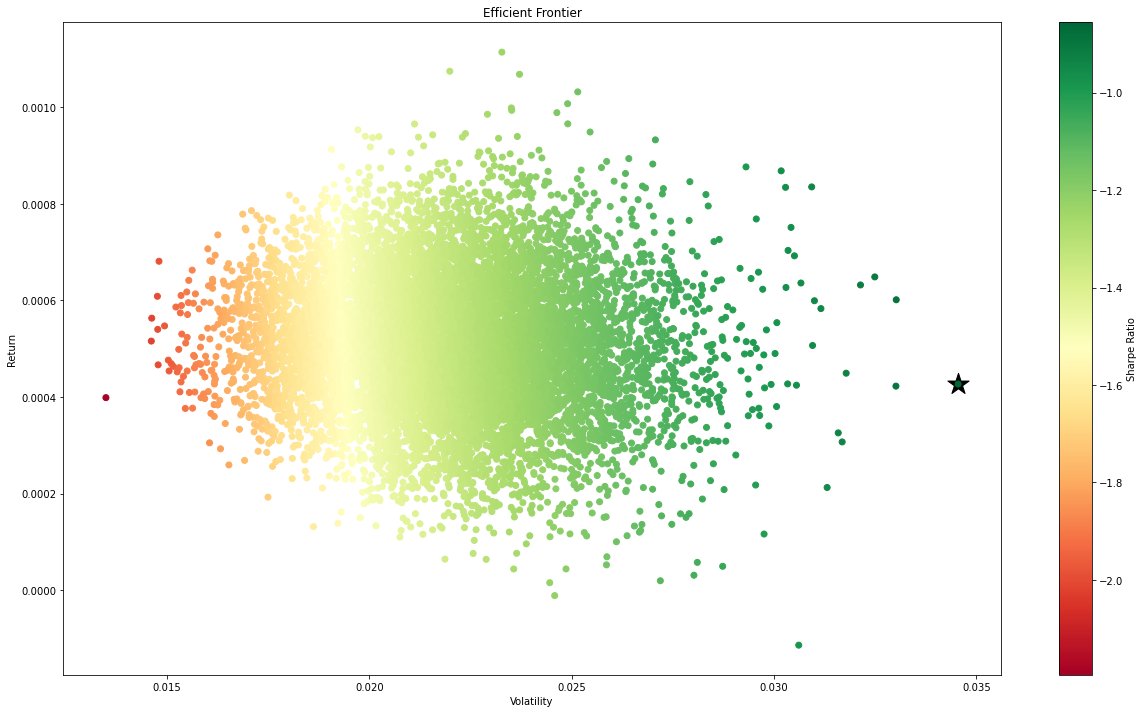

In [34]:
# Step 3: Plotting the efficient frontier
plt.figure(figsize=[21, 12])
plt.scatter(portfolio_volatilities[max_sharpe_idx], portfolio_returns[max_sharpe_idx], c="black",marker='*', s=500) # Highlight the max Sharpe ratio
plt.scatter(portfolio_volatilities, portfolio_returns, c=sharpe_ratios, cmap='RdYlGn')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.colorbar(label='Sharpe Ratio')
plt.title('Efficient Frontier')
plt.show()

In [35]:
# Print the optimal portfolio
print("Optimal Portfolio Weights:")
print(pd.Series(max_sharpe_portfolio * 100, index=db.columns))
print(max(sharpe_ratios))

Optimal Portfolio Weights:
ACLS         6.678073
FUBO        25.173459
MSFT         0.370763
MSTR        24.188549
TSLA        13.745396
AAPL         6.059338
COP          1.642439
COST         1.779364
HD           1.036913
HESM        13.869013
X:BTCUSD     5.456694
dtype: float64
-0.8559399887370879
